# LSH


# Imports

In [ ]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image
import os
from os import path
from pathlib import Path
import shutil



# Trial and Error Code

In [ ]:
q = [1,2,3,4,5]
database = np.array([[2,8,9,7,6],[3,4,5,6,7], [2,4,5,6,7], [1,2,3,4,5]])
indexes = np.array([0,1,3])
descriptors = database[indexes]
#descriptors = np.array([[1,2,3,4,5],[3,4,5,6,7], [2,4,5,6,7]])
distances = np.linalg.norm(q - descriptors, axis=1)
rank = distances.argsort() #ascending scores
distances, rank, descriptors[rank], indexes[rank], database[indexes[rank]]

(array([9.11043358, 4.47213595, 0.        ]),
 array([2, 1, 0]),
 array([[1, 2, 3, 4, 5],
        [3, 4, 5, 6, 7],
        [2, 8, 9, 7, 6]]),
 array([3, 1, 0]),
 array([[1, 2, 3, 4, 5],
        [3, 4, 5, 6, 7],
        [2, 8, 9, 7, 6]]))

# 1. Create

In [ ]:
def create_index(l, k, d, binary, seed):
  """
  Arguments:
            l(int) is the number of hash families g of the index
            k(int) is the number of hash functions h in every hash family g 
            d(int) is the dimensionality of the vectors in the database
            binary(bool) to indicate binary LSH
            seed(int) is for rand number gen reproducability
  
  Returns:
            The index G as a list of hash families [g(1),...,g(l)]
  """
  #set the seed
  np.random.seed(seed)
  #return G = [g(1),...,g(l)] = concat(create_hash_function)
  G = [create_hash_function(k , d, binary) for i in range(0, l)]
  return G

In [ ]:
def create_hash_function(k, d, binary, w=4, mean=0, std=1):
  """
  Arguments:  
            k(int) is the number of h functions
            d(int) is the dimensionality of vectors x(i)
            binary(bool) to indicate binary LSH
            w(float) is the weight (default=4) [only if binary is false]
            mean and std(float) are the parameters of the gauss distribution [only if binary is false] (default=0 and 1 respectively)
  
  Returns:
            A hash family g such that:
              if binary --> returns g=[i(1),...,i(k)] where i is a random index in range (0, d)
                   else --> returns g=[[x(1), w(1), b(1)],...,[x(k), w(k), b(k)]]  
  """
  if binary:
    #Sample k indecies between 0 and d without replacement
    rand_index = np.array(random.sample(range(0, d), k))
    #Sort the sampled indecies
    rand_index.sort()
    return rand_index
  else:
    #def [x(1),...,x(k)] random vectors from gauss distrib
    x = [np.random.normal(mean, std, d) for i in range(0, k)]
    #def [b(1),...,b(k)] random scalars
    b = np.random.uniform(0, w, k)
    #return g = [[x(1), w(1), b(1)],...,[x(k), w(k), b(k)]] 
    g = [[x[i], w, b[i]] for i in range(0, k)]
    return g


# 2. Insert

In [ ]:
def index_database(l, k, database, binary=False, test=False):
  """
  Arguments:
            l(int) is the number of hash families g
            k(int) is the number of hash functions h for each hash family
            database is a list of object descriptors where each object descriptor is a vector (1xd)
            binary(bool, default False) to indicate binary LSH
            test(bool, default False) to indicate whether or not to display tqdm progress bar (if True, don't display it)
  Returns:
            G=list of hash families [g(1),...,g(l)]
  """
  #empty directory if it exists (for cleaning purposes)
  for i in range(l):
    if path.exists(str(i)+"/"):
      shutil.rmtree(str(i)+"/")

  #seed for reproducability
  seed = 56
  #create_index
  G = create_index(l, k, len(database[0]), binary, seed)
  #insert_object for all objects
  for i in tqdm(range(len(database)), disable=test):
    insert_object(G, (i, database[i]), binary)
  return G

In [ ]:
def binarize(database, mean_vector=None, test=False):
  """
  Arguments:
            database(matrix(nxd)) is the database to binarize
            mean_vector(vector(1xd)) to use a reference mean to binarize or to generate it if None(default)
            test(bool, default=False) to indicate whether or not to display tqdm progress bar (if True, don't display it)
  
  Returns:
            binarized_database(binary matrix (nxd))
  """
  
  #to be used for the training set
  if mean_vector is None:
    #calculate the mean vector of the database if it's not specified in the arguments of the function
    mean_vector = database.mean(axis=0)
    binarized_database = []
    #for every vector in the database, do component-wise comparison with the mean vector and assign 0 if a component is 
    #less than the corresponding component in the mean vector and assign 1 otherwise
    for vector in tqdm(database, disable=test):
      binary_vector = [0 if vector[i] < mean_vector[i] else 1 for i in range(len(vector))]
      binarized_database.append(binary_vector)
    #return the binarized database
    return np.array(binarized_database), mean_vector
  

  #to be used for the queries/test set
  else:
    #do the component-wise comparison with the passed mean vector and apply the same policy as before
    binarized_database = []
    for vector in tqdm(database, disable=test):
      binary_vector = [0 if vector[i] < mean_vector[i] else 1 for i in range(len(vector))]
      binarized_database.append(binary_vector)
    #return the binarized database
    return np.array(binarized_database)

In [ ]:
def insert_object(G, p, binary):
  """
  Arguments:
            G is the index represented as a list of hash families [g(1),...,g(l)]
            p(tuple (id, descriptor)) is the database object
            binary(bool) to indicate binary LSH
  Inserts an object identifier p(id) inside buckets=hash(p(descriptor)) for every g family 
  """
  #for each g(i), compute_hash(g(i), p) then insert in bucket g(p) [file] the identifier of p
  for i in range(0, len(G)):
    bucket = compute_hash(G[i], p[1], binary)
    if not os.path.exists(str(i)):
      os.mkdir((str(i))) 
    f =  open(str(i)+"/"+bucket,"a+")
    f.write(str(p[0]))
    f.write('\n')
    f.close()

In [ ]:
def compute_hash(g, p, binary):
  """
  Arguments:
            g is a hash family = list of hash functions h = [[x(1), w(1), b(1)],...,[x(k), w(k), b(k)]] if binary is false
                               = list of random indecies i = [i(i),...,i(k)] if binary is true 
            p(vector (1xd))is a database vector
            binary(bool) to indicate binary LSH
  
  Returns:
            bucket(string): The hash value of the object p computed as:
                            floor((x.p + b)/w) if not binary
                            p[i(1),..,i(k)] if binary

  """
  bucket = ""
  if binary:
    #extract the binary values of the indecies
    vals = p[g]
    #create a binary string from those values
    bucket = ''.join(map(str, vals))

  else:
    #compute the dot product between x and p for every x in every hash function h and concatenate the results in a string
    for h in g:
      bucket += str(int(abs((np.dot(np.array(h[0]), p)+h[2])/h[1])))
  #return the hash value
  return bucket

# 3. Query 

In [ ]:
def get_knn(G, q, k, database, binary, test=False):
  """
  Arguments:  
            G(list of hash families) the index
            q(vector(1xd)) descriptor of the query
            k(int) is the number of neighbours under query
            database is list of descriptors (nxd)
            binary(bool) to indicate binary LSH
            test(bool, default=False) to indicate whether or not to display tqdm progress bar (if True, don't display it)

  """
  #list = retrieve(G, q) --> retrieve all similar objects
  retrieved_index = retrieve(G, q, database, binary, test, k)
  #return list [:k]  --> return k nearest objects
  return retrieved_index[:k]

In [ ]:
##order retrieved objects based on number of appearances in the L buckets + remove duplicates
def retrieve(G, q, database, binary, test, k, max_trial=5, max_counter=10, threshold=1):
  """
  Arguments:
            G(list of hash functions) is the index 
            q (descriptor(1xd)) is the query 
            database is list of descriptors (nxd)
            binary(bool) to indicate binary LSH
            test(bool) to indicate whether or not to display tqdm progress bar (if True, don't display it)
            
            Related to the unused optimization:
            k(int) number of desired objects
            max_trial(int, default=5) number of trials before returning less than k objects
            max_counter(int, default=10) number of trials to get a different similar hash with the same hamming distance (only if file was not found)
            threshold(int, default=1) min hamming distance to introduce perturbation to query (only for binary)
  Returns:
            retrieved_objects: an ordered list of object identifiers with respect to similarity in descending order
  
  """

  #Uncomment to try the optimization
  """
  retrieved_objects = set()
  trial = 0

  while(len(retrieved_objects)<k and trial<max_trial):
    buckets=[]
    for i in tqdm(range(0, len(G)), disable=test):
      counter = 0
      bucket = compute_hash(G[i], q, binary) if trial == 0 else get_similar_hash(bucket, threshold+trial-1, binary)
      while(not path.exists(str(i)+"/"+bucket) and counter < max_counter):
        bucket = get_similar_hash(bucket, threshold+trial, binary)
        counter+=1
      if not path.exists(str(i)+"/"+bucket):
        print('I could not find file')
        continue
      f = open(str(i)+"/"+bucket, "r")
      objects = f.readlines()
      f.close()
      buckets.append(objects)
    retrieved_from_trial = [obj for sublist in buckets for obj in sublist]
    retrieved_objects.update(retrieved_from_trial)
    trial+=1
  """

  #compute_hash(q) for each g(i) in G then retrieve the list of id inside each bucket
  buckets=[]
  for i in tqdm(range(0, len(G)), disable=test):
    bucket = compute_hash(G[i], q, binary)
    if not path.exists(str(i)+"/"+bucket):
      continue
    f = open(str(i)+"/"+bucket, "r")
    objects = f.readlines()
    f.close()
    buckets.append(objects)

  #flatten the retrieved ids
  retrieved_objects = [obj for sublist in buckets for obj in sublist]
  #create a set to remove duplicate ids
  retrieved_objects = set(retrieved_objects)

  #convert the set into an np array
  retrieved_objects = np.array([int(retrieved_object) for retrieved_object in retrieved_objects])
  
  #return from the function if nothing was retrieved
  if retrieved_objects.size==0:
    return retrieved_objects

  #compute the real distances between the retrieved objects and the query
  # if binary, compute the hamming distance
  # if not binary, compute the euclidean norm 
  descriptors = database[retrieved_objects]
  if binary:
    distances = np.count_nonzero(np.logical_xor(q, np.array(descriptors)), axis=1) 
  else:
    distances = np.linalg.norm(q - np.array(descriptors), axis=1)

  #return the ordered list of objects
  rank = distances.argsort() #ascending scores
  return retrieved_objects[rank]

In [ ]:
#Possible optimization -- not used in the project -- was just for trial
def get_similar_hash(bucket, threshold, binary):
  """
  Arguments:
            bucket(string): the bucket of the query to be changed
            threshold(int): the hamming distance between the query bucket and the modified query bucket
            binary(bool): to indicate binary LSH (only supported version for this optimization)
  Returns:
            modified bucket string
  """
  print('I am getting similar hash'+str(threshold))
  if binary:
    #convert the string into a list
    bucket = list(bucket)
    #pick random indices in the list equal to the hamming distance
    rand_index = np.array(random.sample(range(0, len(bucket)), threshold))
    #flip the values for the picked indices to achieve the required hamming distance
    for index in rand_index:
      if bucket[index]=='0':
        bucket[index]='1'
      else:
        bucket[index]='0'
    #return the modified bucket
    return "".join(bucket)

#  Testing

In [ ]:
"""
! gdown --id 1SbHWZBmgEj6PIPthx8wU6ZHPl-nWPG4Z
! mkdir -p data && unzip -q -d data 100-bird-species.zip
! rm 100-bird-species.zip

#Downloading the Extracted Features into the runtime
! gdown --id 1tmYwMHToPcXV5dLxRksOLgJKQr3n1W5p
! gdown --id 1b4IWtSK_kFZhGH3Sa2LQMVMjPSDhAydY
! gdown --id 1u7d1Sv06VKijEYoKAMCcTpsjBcHGQSFq

#Downloading the test, valid and train csv files into a dataframe
! gdown --id 1-3QBMtamrpykyq-_I0-IqnjzWJToVUZ5
! gdown --id 1-FSxvneVXA9GjHqgbdOsqnyMqDL9_NfO
! gdown --id 1-3krUU0JxtryQJ2GqtiXHW40xhx-lEv6

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
valid = pd.read_csv('valid.csv')  

#Loading into a numpy array
descriptors_train = np.load("train_descriptors.npy")
descriptors_test = np.load("test_descriptors.npy")
descriptors_valid = np.load("valid_descriptors.npy")

#Remove the files from runtime
! rm train_descriptors.npy
! rm test_descriptors.npy
! rm valid_descriptors.npy
! rm train.csv
! rm train.csv
! rm valid.csv
! rm test.csv 
"""

Downloading...
From: https://drive.google.com/uc?id=1SbHWZBmgEj6PIPthx8wU6ZHPl-nWPG4Z
To: /content/100-bird-species.zip
100% 1.25G/1.25G [00:07<00:00, 175MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tmYwMHToPcXV5dLxRksOLgJKQr3n1W5p
To: /content/train_descriptors.npy
100% 388M/388M [00:03<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1b4IWtSK_kFZhGH3Sa2LQMVMjPSDhAydY
To: /content/test_descriptors.npy
100% 13.3M/13.3M [00:00<00:00, 36.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1u7d1Sv06VKijEYoKAMCcTpsjBcHGQSFq
To: /content/valid_descriptors.npy
100% 13.3M/13.3M [00:00<00:00, 76.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-3QBMtamrpykyq-_I0-IqnjzWJToVUZ5
To: /content/test.csv
100% 83.9k/83.9k [00:00<00:00, 13.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-FSxvneVXA9GjHqgbdOsqnyMqDL9_NfO
To: /content/train.csv
100% 2.63M/2.63M [00:00<00:00, 68.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-3krUU

In [ ]:
#! rm -rf 0/ 1/ 2/ 3/ 4/ 5/ 6/

In [ ]:
#G, bin_database, mean_vector = index_database(7, 5, descriptors_train, binary=True)

  0%|          | 0/47332 [00:03<?, ?it/s]

GYRFALCON


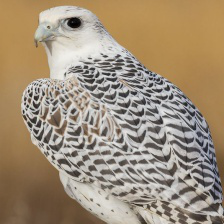

In [ ]:
#405
"""
index = 740
query_url = test.filepaths.iloc[index]

# load the image (a PIL.Image object is returned)
query_image_pil = tf.keras.utils.load_img(query_url, interpolation='bilinear')
print(test['labels'][index])
query_image_pil
"""

In [ ]:
"""query_descriptor = descriptors_test[index]
query_binary_descriptor = np.array([0 if query_descriptor[i] < mean_vector[i] else 1 for i in range(len(query_descriptor))])

query_binary_descriptor"""

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
"""l = get_knn(G, query_binary_descriptor, 10, bin_database, binary=True)
l"""

  0%|          | 0/7 [00:00<?, ?it/s]

array([21588, 21587, 39917, 21515, 21511, 21510, 21505, 21563, 21576,
       21571])

In [ ]:
from IPython.display import display
from ipywidgets import HBox, Image, HTML


def display_image(image_path, title='', txt=''):
  """ Displays an image with optional title and text next to it using iPython
  widgets (works in Jupyter/Colab environments).
      
  Args:
    image_path (string): path to the image to show.
    title (string): header text to show next to the image.
    txt (string): text to show under the title header.
  """
  image_widget = Image.from_file(image_path, width=200, height=100)
  txt = txt.replace('\n', '<br>')
  text_widget = HTML('<p><b>{}</b></p><p>{}</p>'.format(title, txt))
  widget = HBox([image_widget, text_widget])
  display(widget)

def show_results(image_paths, scores, captions=None):
  """
  Shows results of a similarity search. Lists of image paths, scores, and
  (optionally) captions must be of the same length and follow the same order.

  Args:
    image_paths (ndarray or list): ordererd paths of images to be shown.
    scores (ndarray or list): ordered scores values to be shown next to images.
    captions (ndarray or list): ordered strings of captions to be shown; if
                                None, no caption is shown. Defaults to None.
  
  """
  if captions is None:
    captions = [''] * len(scores)  # just all empty strings

  for image_path, score, caption in zip(image_paths, scores, captions):
    title = 'score: {:.3f}'.format(score)
    display_image(image_path, title, caption)

In [ ]:
"""for index in l:
  query_url = train.filepaths.iloc[index]

  # load the image (a PIL.Image object is returned)
  query_image_pil = tf.keras.utils.load_img(query_url, interpolation='bilinear')
  print(train['labels'][index])
  query_image_pil
  display_image(query_url)
"""

GYRFALCON


GYRFALCON


SNOWY OWL


GYRFALCON


GYRFALCON


GYRFALCON


GYRFALCON


GYRFALCON


GYRFALCON


GYRFALCON
